In [1]:
#show the figures buildin the notebook
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #Used to load the OCTAVE *.mat files
import scipy.misc #Used to show matrix as an image
from scipy import optimize
import matplotlib.cm as cm #Used to display images in a specific colormap
import random
from PIL import Image

In [2]:
fileName = 'data/ex4data1.mat'
mat = scipy.io.loadmat(fileName)

X = mat['X']
Y = mat['y']
Y = Y - 1#Y[Y==10]=0   # convert 10 to 0
print ("'X' shape:%s.X[0] shape:%s" %(X.shape,X[0].shape))
print ("'y' shape:%s. Unique elements in y:%s" %(Y.shape,np.unique(Y)))

'X' shape:(5000, 400).X[0] shape:(400,)
'y' shape:(5000, 1). Unique elements in y:[0 1 2 3 4 5 6 7 8 9]


visualise the digit has done


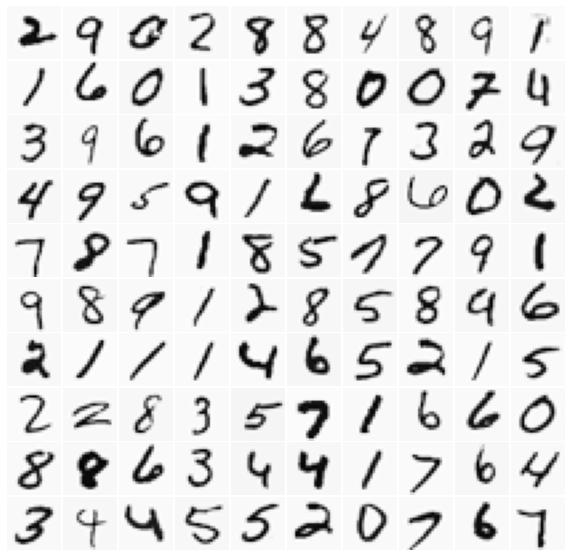

In [3]:
def getDatumImg(row):
    """
    function that is handed a single np array with shape 1*400,
    create an image from object from it, and return.
    """
    width, height = (20,20)
    return row[1:].reshape(width, height)

def displayData(X, example_width=None, figsize=(10, 10)):
    """
    Displays 2D data stored in X in a nice grid.
    """
    # Compute rows, cols
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promote to a 2 dimensional array
    else:
        raise IndexError('Input X should be 1 or 2 dimensional.')

    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n / example_width

    # Compute number of items to display
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = plt.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        ax.imshow(X[i].reshape(example_width, example_width, order='F'),
                  cmap='Greys', extent=[0, 1, 0, 1])
        ax.axis('off')

m = X.shape[0]
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]

displayData(sel)
print ('visualise the digit has done')

In [4]:
X = np.insert(X,0,1,axis=1)

In [5]:
def sigmoid(arr, theta):
    """
    function that sigmoid both the input samples and the parameters
    """
    z = np.dot(arr, theta)
    return 1.0 / (1 + np.exp(-z))

def randInitializeWeights(input_layer_size, hidden_layer_size):
    """
    episilon = np.sqrt(6)/np.sqrt(Lin + Lout)
    Lin = the number of input layer unit
    Lout = the number of the adjacent layer unit
    """
    episilon = 0.12
    return np.random.rand(input_layer_size,hidden_layer_size+1) * 2.0 * episilon - episilon


def sigmoidGradient(arr, theta):
    sig = sigmoid(arr, theta)
    return sig * ( 1 - sig)

def reshapeParams(nn_params, input_layer_size=400, hidden_layer_size=25, num_labels=10):
    """
    function is used to reshape the input parameter:theta with type:list as 2 arrays, return it
    """
    #print ("the type of nn_params in reshapeParams is:%s" % type(nn_params))
    theta1 = np.array(nn_params[:(input_layer_size+1) * hidden_layer_size]).reshape((hidden_layer_size,input_layer_size + 1))
    theta2 = np.array(nn_params[-num_labels * (hidden_layer_size+1):]).reshape((num_labels, hidden_layer_size+1))
    return (theta1, theta2)

def formatY(Y,num_labels=10):
    result = np.zeros((Y.shape[0],num_labels))
    for idx in range(Y.shape[0]):
        result[idx,Y[idx,0]] = 1
    return result

def nnCostFunction(nn_params,  X, Y, lamda=0.0,input_layer_size=400, hidden_layer_size=25,num_labels=10):
    """
    function to calculate the loss error of the samples
    """
    #print ("the type of nn_params in nnCostFunction is:%s" % type(nn_params))

    theta1, theta2 = reshapeParams(nn_params, input_layer_size, hidden_layer_size, num_labels)

    a1 = sigmoid(X, theta1.T) # m * hidden_layer_size
    a1 = np.insert(a1,0, 1, axis=1) # m * (hidden_layer_size + 1)
    #print a1[:10]
    #print "a1's shape:(%d,%d)" % a1.shape

    a2 = sigmoid(a1, theta2.T) # m * num_labels
    #print a2[:10]
    #print "a2's shape:(%d,%d)" % a2.shape

    # format Y from m * 1 to a m*num_labels array
    fY = formatY(Y,num_labels)
    #print "Y's shape:(%d,%d)" % fY.shape

    J = -(np.sum(np.log(a2[fY==1])) + np.sum(np.log(1.0 - a2[fY==0])))
    m = len(X)

    J = J/m + lamda * (np.sum(theta1**2) + np.sum(theta2**2)) /(2*m)
    print ("cost value:%f" % J)
    return J

paramFile = 'data/ex4weights.mat'
params = scipy.io.loadmat(paramFile)
Theta1 = params['Theta1']
Theta2 = params['Theta2']

input_layer_size=400 # NO of features of samples
hidden_layer_size=25 # NO of Hidden Units 
num_labels = 10 # NO of Output Units

theta = np.append(Theta1.flatten(),Theta2.flatten())


print( nnCostFunction(theta,X,Y,0.0))

print (nnCostFunction(theta,X,Y,1.0))

cost value:0.287629
0.2876291651613189
cost value:0.384488
0.384487796242894


In [6]:
def backpropagation(nn_params,  X, Y, lamda=0.0,input_layer_size=400, hidden_layer_size=25,
                   num_labels=10):
    theta1, theta2 = reshapeParams(nn_params, input_layer_size, hidden_layer_size, num_labels)
    a2 = sigmoid(X, theta1.T) # m * hidden_layer_size
    a2 = np.insert(a2,0, 1, axis=1) # m * (hidden_layer_size + 1)
    a3 = sigmoid(a2, theta2.T) # m * num_labels

    # format Y from m * 1 to a m*num_labels array
    fY = formatY(Y,num_labels)

    delta3 = a3 - fY   # m * num_labels
    delta2 = np.dot(delta3, theta2[:,1:]) * sigmoidGradient(X, theta1.T)   # m * (hidden_layer_size)

    grad2 = np.dot(delta3.T, a2) / X.shape[0] # num_labels * (hidden_layer_size+1)
    grad2[:,1:] = grad2[:,1:] + (lamda * theta2[:,1:]/X.shape[0]) 
    grad1 = np.dot(delta2.T, X) / X.shape[0] # (hidden_layer_size) * (input_layer_size+1)
    grad1[:,1:] = grad1[:,1:] + (lamda * theta1[:,1:]/X.shape[0])

    return np.append(grad1.flatten(),grad2.flatten())

def computeNumericalGradient(mytheta, X, Y, mylambda=0.0,input_layer_size=400, hidden_layer_size=25,
                   num_labels=10):
    """
    mytheta is a flatten array
    """
    print (input_layer_size,hidden_layer_size,num_labels)
    print (mytheta.shape)
    ngrad = np.zeros((len(mytheta),1))
    episode = 0.0001
    for i in range(len(mytheta)):
        theta_plus = mytheta.copy()
        theta_plus[i]=theta_plus[i] + episode
        theta_minus = mytheta.copy()
        theta_minus[i] = theta_minus[i] - episode
        ngrad[i]=(nnCostFunction(theta_plus,  X, Y,mylambda,input_layer_size,hidden_layer_size,num_labels) - nnCostFunction(theta_minus, X, Y,mylambda,input_layer_size,hidden_layer_size,num_labels))/ (2 * episode)

    return ngrad

def checkNNGradient(mylambda=0.0):
    input_layer_size = 3;
    hidden_layer_size = 5;
    num_labels = 3;
    m = 5;
    theta1 = randInitializeWeights(hidden_layer_size,input_layer_size);
    theta2 = randInitializeWeights(num_labels,hidden_layer_size);
    X = randInitializeWeights(m, input_layer_size - 1)
    X = np.insert(X,0,1,axis=1)
    Y = (np.arange(m) % 3).reshape(m,1)

    ngrad = computeNumericalGradient(np.append(theta1.flatten(),theta2.flatten()),X,Y,mylambda,input_layer_size,hidden_layer_size,num_labels)

    print (ngrad.shape)

    grad = backpropagation(np.append(theta1.flatten(),theta2.flatten()),  X, Y, mylambda,input_layer_size, hidden_layer_size,num_labels)
    print (grad.shape)
    #print (ngrad.flatten(),grad.flatten())
    print ("%.15f" % (norm(ngrad.flatten() - grad) / norm(ngrad.flatten() + grad)))

def norm(arr):
    return np.sqrt(np.dot(arr,arr.T))
checkNNGradient()

3 5 3
(38,)
cost value:2.083143
cost value:2.083143
cost value:2.083143
cost value:2.083143
cost value:2.083143
cost value:2.083143
cost value:2.083143
cost value:2.083143
cost value:2.083142
cost value:2.083144
cost value:2.083143
cost value:2.083143
cost value:2.083143
cost value:2.083143
cost value:2.083143
cost value:2.083143
cost value:2.083144
cost value:2.083142
cost value:2.083143
cost value:2.083143
cost value:2.083143
cost value:2.083143
cost value:2.083143
cost value:2.083143
cost value:2.083143
cost value:2.083143
cost value:2.083143
cost value:2.083143
cost value:2.083143
cost value:2.083143
cost value:2.083143
cost value:2.083143
cost value:2.083144
cost value:2.083142
cost value:2.083143
cost value:2.083143
cost value:2.083143
cost value:2.083143
cost value:2.083143
cost value:2.083143
cost value:2.083152
cost value:2.083134
cost value:2.083147
cost value:2.083139
cost value:2.083147
cost value:2.083139
cost value:2.083147
cost value:2.083139
cost value:2.083147
cost val

In [7]:
checkNNGradient(3)

3 5 3
(38,)
cost value:2.176437
cost value:2.176426
cost value:2.176427
cost value:2.176435
cost value:2.176438
cost value:2.176424
cost value:2.176436
cost value:2.176427
cost value:2.176433
cost value:2.176430
cost value:2.176437
cost value:2.176425
cost value:2.176426
cost value:2.176436
cost value:2.176430
cost value:2.176433
cost value:2.176425
cost value:2.176438
cost value:2.176438
cost value:2.176425
cost value:2.176438
cost value:2.176425
cost value:2.176426
cost value:2.176437
cost value:2.176434
cost value:2.176429
cost value:2.176428
cost value:2.176435
cost value:2.176425
cost value:2.176438
cost value:2.176426
cost value:2.176437
cost value:2.176424
cost value:2.176439
cost value:2.176438
cost value:2.176424
cost value:2.176436
cost value:2.176427
cost value:2.176435
cost value:2.176428
cost value:2.176445
cost value:2.176418
cost value:2.176442
cost value:2.176420
cost value:2.176435
cost value:2.176428
cost value:2.176442
cost value:2.176420
cost value:2.176431
cost val

In [8]:
 nnCostFunction(theta,  X, Y, lamda=3.0,input_layer_size=400, hidden_layer_size=25,num_labels=10)

cost value:0.578205


0.5782050584060441

In [9]:
init_theta1 = randInitializeWeights(25,400)
init_theta2 = randInitializeWeights(10,25)
init_theta = np.append(init_theta1.flatten(),init_theta2.flatten())
print (len(init_theta)==len(theta))
res = optimize.minimize(nnCostFunction,init_theta,args=(X,Y,1.0,400,25,10),method='TNC',
                        jac=backpropagation,options={'maxiter':100,'disp':True})

True
cost value:7.218617
cost value:7.218617
cost value:7.218617
cost value:3.533431
cost value:3.533431
cost value:3.533431
cost value:3.244776
cost value:3.244776
cost value:3.244776
cost value:3.244776
cost value:3.155689
cost value:3.153485
cost value:3.141185
cost value:3.141185
cost value:3.141185
cost value:2.902489
cost value:2.902489
cost value:2.902489
cost value:2.902489
cost value:2.287189
cost value:2.256244
cost value:2.189366
cost value:2.189366
cost value:2.189366
cost value:2.189366
cost value:2.189366
cost value:2.189365
cost value:11.974088
cost value:3.988618
cost value:1.922713
cost value:1.875918
cost value:1.831865
cost value:1.831865
cost value:1.831865
cost value:1.831865
cost value:1.831865
cost value:1.831865
cost value:1.376252
cost value:1.376252
cost value:1.376252
cost value:1.196149
cost value:1.196149
cost value:1.196149
cost value:1.196149
cost value:1.196149
cost value:1.196149
cost value:1.196149
cost value:1.196149
cost value:1.196149
cost value:1.1

In [10]:
ret_theta = res.x
ret_theta1 = np.array(ret_theta)[:25*401].reshape(25,401)
ret_theta2 = np.array(ret_theta)[25*401:].reshape(10,26)

def predict(X,Y,ret_theta1, ret_theta2):
    a2 = sigmoid(X, ret_theta1.T)
    a2 = np.insert(a2,0,1,axis=1)
    a3 = sigmoid(a2, ret_theta2.T)
    ret = np.argmax(a3,axis=1).reshape(-1,1)
    return np.mean(Y==ret) * 100

print ("the precision is:%f" % predict(X,Y,ret_theta1, ret_theta2))


the precision is:94.280000


In [11]:
import scipy.io #Used to load the OCTAVE *.mat files
import numpy as np
import sys
sys.path.append ('../src')
from NeuralNetwork import NNClassifier
from ML_utils import UTIL_formatY,backward_prop,backpropagation
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix,classification_report


nn_config={'n_a1':400,'n_a2':25,'n_a3':10 }   # Configuración de red NN , input layer , hidder layers , output layer
sgd_dict =   {'steps':150,'learning_rate':0.00099}
opt_dict =   {}
method ='Optimize'
nn = NNClassifier(optimization=method,nn_config=nn_config,debug=False,kargs=opt_dict)
nn.thetas ['Theta1'] = ret_theta1
nn.thetas ['Theta2'] = ret_theta2

prediction,_ = nn.forward_prop (X)
result = np.argmax(prediction,axis=1).reshape(-1,1)
#prediction[prediction >= 0.5] = 1
#prediction[prediction < 0.5] = 0
#accuracy = accuracy_score (fY_train.flatten(),prediction.flatten())
accuracy = np.mean(Y==result) * 100
print ('Trainig set accuracy :' , accuracy  )

Trainig set accuracy : 94.28


In [12]:
nn = NNClassifier(optimization=method,nn_config=nn_config,debug=False,kargs=opt_dict)

fY = UTIL_formatY (Y,num_labels=10)   # Pasamos de y=[3] a fY=[0 0 0 1 0 0 0 0 0]
_= nn.optimize (X,fY,l2_lambda=1.0)


cost  6.319395251794778
cost  6.319395088268802
cost  6.319395184839099
cost  3.3305971098119547
cost  3.3305971009844466
cost  3.330597109389576
cost  3.3305970780753453
cost  3.061769666010664
cost  3.0617696261896032
cost  3.061769567199932
cost  2.649708282749219
cost  2.6497082095050857
cost  2.649708199791805
cost  2.649707872379928
cost  2.064919180971395
cost  1.9238100579054223
cost  1.8676243065922762
cost  1.867624234645302
cost  1.8676242777163556
cost  1.867624277777258
cost  1.86762424490998
cost  1.867623523942251
cost  1.4666560945519183
cost  1.3647803340253852
cost  1.3647802661475585
cost  1.3647803046839257
cost  1.364780320425758
cost  1.3647803154026812
cost  1.364780301214898
cost  1.364780264821234
cost  1.0559289444635338
cost  1.0341202656306472
cost  1.0341202200909554
cost  1.034120255103895
cost  1.034120255002312
cost  1.0341202520148802
cost  1.034120249297817
cost  1.0341202535550884
cost  1.0341202379194028
cost  1.0341202209828058
cost  1.0341201495420

In [13]:
prediction,_ = nn.forward_prop (X)
result = np.argmax(prediction,axis=1).reshape(-1,1)
print (result)

[[9]
 [9]
 [9]
 ...
 [8]
 [8]
 [8]]
